In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats

import os

In [2]:
import importlib
import plot
plot = importlib.reload(plot)

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
DATA_PATH = os.path.join("data", "large-fam_height_permitted-subset.csv")
SAVE_FIG_DIR = "figure5"

In [4]:
PLOT_THICKENS = True
if PLOT_THICKENS:
    # sns.plotting_context("talk")
    CUSTOM_SNS_RC = {'xtick.labelsize': 13.5, 'ytick.labelsize': 13.5, 'legend.fontsize': 13.0, 
                                                 'axes.labelsize': 14, 'axes.titlesize': 15}
    # sns.set_context("paper", font_scale=1.4, rc=CUSTOM_SNS_RC)
    sns.set_context("talk", font_scale=1, rc=CUSTOM_SNS_RC)

# Compare to real large families

#### Load Data

In [5]:
data = pd.read_csv(DATA_PATH)
data.head()

FID  IID  age  sex   predicted    measured
0  274    1   45    1  171.985080  172.392999
1  274    2   43    2  167.724043  162.669588
2  274    3   42    2  174.885904  174.006001
3  274    4   41    2  176.036211  166.437195
4  274    5   38    2  176.432082  169.612194

In [6]:
print(data.shape)
parents = data.loc[data["IID"] > 90]
offspring = data.drop(index=parents.index)
print(offspring.shape, parents.shape)

(308, 6)
(268, 6) (40, 6)


### Analyze

#### Gain vs. # of offspring

##### Parents correlation

In [79]:
fathers = parents.query("IID==91").set_index("FID")["predicted"]
mothers = parents.query("IID==92").set_index("FID")["predicted"]
parents_correlation = fathers.corr(mothers)
print(parents_correlation)

0.05156897050399943


##### Gain

In [80]:
gain = offspring.groupby("FID")["predicted", "measured"].agg(["max", "mean"])
gain = gain.xs("max", axis="columns", level=1) - gain.xs("mean", axis="columns", level=1)
gain.head()

predicted  measured
FID                     
274   5.252106  9.037921
275   8.497974  6.444791
277   6.692024  5.995120
278  11.176159  6.615244
279  10.259785  7.083721

In [81]:
gain = gain.join(offspring.groupby("FID").size().rename("size"))
gain.head()

predicted  measured  size
FID                           
274   5.252106  9.037921    11
275   8.497974  6.444791     7
277   6.692024  5.995120    13
278  11.176159  6.615244    13
279  10.259785  7.083721     8

In [82]:
gain_by_size = gain.groupby("size").agg(["mean", "sem"])  # shape: (sizes, {predicted, measured} x {mean, sem})
gain_by_size = gain_by_size.stack(level=0).swaplevel().sort_index() # rearrange: ({predicted, measured} x size, {mean, sem})
gain_by_size = gain_by_size.reset_index()
gain_by_size = gain_by_size.rename(columns={"level_0": "type"})
gain_by_size["ci95"] = stats.norm.ppf(0.95) * gain_by_size["sem"]
gain_by_size.sample(3)

type  size      mean       sem      ci95
21  predicted    20  6.790628       NaN       NaN
13  predicted     7  5.913620  1.465907  2.411202
9    measured    15  6.615423       NaN       NaN

##### Plot

In [83]:
def gauss_max_exp(n, approx=False, approx_scale=0.77):
    if approx:
        phi_max = np.sqrt(np.log(n)) * approx_scale
    else:
        gamma = 0.5772
        phi_max = stats.norm().ppf(1 - 1/n)
        phi_max += gamma / (n * stats.norm().pdf(phi_max))
    return phi_max

In [84]:
APPROX_MAX = False

In [85]:
n_sibs_domain = np.linspace(2, gain_by_size["size"].max(), 100)
r2_score = 0.273
h_p = np.sqrt(r2_score)
sigma_y = data["measured"].std()
# rho = np.sqrt(1 - parents_correlation)
rho = np.sqrt(1 - 0)
expected_family_max = gauss_max_exp(n_sibs_domain, APPROX_MAX)

Realized gain

In [87]:
# Get needed values for realized gain - actual height of predicted max and observed mean:
realized_gain = offspring.groupby("FID")["predicted"].idxmax().rename("idx_top_predicted").to_frame()
realized_gain["top_predict_measured"] = offspring.loc[realized_gain["idx_top_predicted"], 
                                                      ["FID", "measured"]].set_index("FID")["measured"]
realized_gain = realized_gain.join(offspring.groupby("FID")["measured"].mean().rename("measured_mean"))

# Discard the no longer needed predicted_idxmax
realized_gain = realized_gain.drop(columns="idx_top_predicted")

# Caclculate realized gain:
realized_gain["realized_gain"] = realized_gain["top_predict_measured"] - realized_gain["measured_mean"]

# Get sizes for each family:
realized_gain = realized_gain.join(offspring.groupby("FID").size().rename("size"))

realized_gain.head()

top_predict_measured  measured_mean  realized_gain  size
FID                                                          
274            176.748900     171.512077       5.236823    11
275            174.207673     167.762881       6.444791     7
277            184.000002     178.004882       5.995120    13
278            168.937973     172.209755      -3.271782    13
279            170.863953     166.649598       4.214355     8

In [88]:
realized_gain_by_size = realized_gain.groupby("size")["realized_gain"].agg(["mean", "sem"])  # shape: (sizes, {mean, sem})
realized_gain_by_size = realized_gain_by_size.reset_index()
realized_gain_by_size["ci95"] = stats.norm.ppf(0.95) * realized_gain_by_size["sem"]
realized_gain_by_size.sample(3)

size       mean       sem      ci95
7    13   2.080709  2.770074  4.556366
2     7   1.415392  2.420005  3.980555
8    14  10.307156       NaN       NaN

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.errorbar(realized_gain_by_size["size"], realized_gain_by_size["mean"],  yerr=realized_gain_by_size["ci95"], 
#             fmt=".", label="Empirical")
ax.scatter(realized_gain_by_size["size"], realized_gain_by_size["mean"], 
           marker=".", label="Empirical")

APPROX_MAX = True
expected_family_max = gauss_max_exp(n_sibs_domain, APPROX_MAX)
theoretical_curve = sigma_y * h_p * expected_family_max * rho / np.sqrt(2)
if APPROX_MAX:
    theoretical_curve *= np.sqrt(2)
ax.plot(n_sibs_domain, theoretical_curve, label="Theoretical", alpha=0.9, color="C1")
ax.legend(loc=(0.02, 0.08))
# ax.legend(loc="lower right")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylabel("Realized gain [cm]")
ax.set_xlabel("# Embryos [n]")
ax.set_title("Large families");

In [18]:
plot.save_fig(fig, "realized-gain-mean-by-nsibs_large-fam" + 
                    ("_approx" if APPROX_MAX else ""),
              SAVE_FIG_DIR)

In [90]:
realized_gain.head()

top_predict_measured  measured_mean  realized_gain  size
FID                                                          
274            176.748900     171.512077       5.236823    11
275            174.207673     167.762881       6.444791     7
277            184.000002     178.004882       5.995120    13
278            168.937973     172.209755      -3.271782    13
279            170.863953     166.649598       4.214355     8

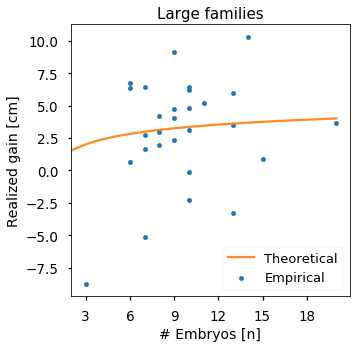

In [91]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.errorbar(realized_gain_by_size["size"], realized_gain_by_size["mean"],  yerr=realized_gain_by_size["ci95"], 
#             fmt=".", label="Empirical")
ax.scatter(realized_gain["size"], realized_gain["realized_gain"], 
           marker=".", label="Empirical")

APPROX_MAX = False
expected_family_max = gauss_max_exp(n_sibs_domain, APPROX_MAX)
theoretical_curve = sigma_y * h_p * expected_family_max * rho / np.sqrt(2)
if APPROX_MAX:
    theoretical_curve *= np.sqrt(2)
ax.plot(n_sibs_domain, theoretical_curve, label="Theoretical", alpha=0.9, color="C1")
# ax.legend(loc=(0.01, 0.1))
# ax.legend(loc=(0.55, 0.16))
ax.legend(loc="lower right")
ax.set_xlim(realized_gain["size"].min() - 1, ax.get_xlim()[1])
ax.xaxis.set_major_locator(MaxNLocator(8, integer=True))
ax.set_ylabel("Realized gain [cm]")
ax.set_xlabel("# Embryos [n]")
ax.set_title("Large families");

In [92]:
plot.save_fig(fig, "realized-gain-by-nsibs_large-fam_pointplot" + 
                    ("_approx" if APPROX_MAX else ""),
              SAVE_FIG_DIR)

### Compare to actual

#### Non-randomized rank-slope plot

In [140]:
ranks = offspring.drop(columns=["age", "sex"]).set_index(["FID", "IID"]).groupby("FID").rank(ascending=False)
# top_ranks = ranks.loc[ranks.groupby("FID").apply(lambda x: (x == 1).any(axis="columns")).values]
top_ranks = ranks.loc[(ranks == 1).any(axis="columns")]

In [142]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for _, row in top_ranks.iterrows():
    measured_rank = row["measured"]
    predicted_rank = row["predicted"]
    marker_size = ((top_ranks["predicted"] == predicted_rank) & 
                   (top_ranks["measured"] == measured_rank)).sum() + 6.5
    if measured_rank != 1:
        ax.plot(["b"], [measured_rank], 
                markersize=marker_size, marker="o", alpha=0.4, color="C0")
    elif predicted_rank != 1:
        ax.plot(["a"], [predicted_rank], 
                markersize=marker_size, marker="o", alpha=0.4, color="C1")
    else:
#         ax.plot(["b"], [measured_rank], 
#                 markersize=marker_size, marker="o", alpha=0.4, color="C0")
#         ax.plot(["a"], [predicted_rank], 
#                 markersize=marker_size, marker="o", alpha=0.4, color="C1")
        ax.plot(["a", "b"], [predicted_rank, measured_rank], 
                marker="o", color="C0", alpha=0.4, 
                markersize=marker_size)
        ax.plot(["a", "b"], [predicted_rank, measured_rank], 
                marker="o", color="C1", alpha=0.4,
                markersize=marker_size)
        continue
    if predicted_rank == 1:
        ax.plot(["a", "b"], [predicted_rank, measured_rank], 
                color="C0", alpha=0.4, zorder=0)
    if measured_rank == 1:  # Plot twice on purpose, to get the brownish color between 1-to-1
        ax.plot(["a", "b"], [predicted_rank, measured_rank], 
                color="C1", alpha=0.4, zorder=0)
ax.set_xticklabels(["Predicted", "Measured"])
ax.set_ylabel("Rank")
ax.yaxis.labelpad = -3
ax.set_title("Rank comparison of top offspring");

In [143]:
plot.save_fig(fig, "large-fam_rank-slope_top_diffsize_n=all",
              SAVE_FIG_DIR)

#### Dot plot

In [122]:
parents, offspring
max_predicted_offspring = offspring.groupby("FID")["predicted"].idxmax()
max_predicted_offspring = offspring.loc[max_predicted_offspring]
offspring_no_max = offspring.drop(max_predicted_offspring.index)

In [123]:
# Sort by family mean:
order = offspring_no_max.groupby("FID").mean().sort_values(by="measured", ascending=False).index
# Sort by family size:
# order = offspring_no_max.groupby("FID").size().sort_values(ascending=False).index
# Sort by FID:
# order = None
order

Int64Index([295, 281, 303, 277, 294, 300, 284, 297, 291, 293, 304, 283, 292,
            290, 278, 298, 286, 280, 296, 274, 288, 301, 282, 299, 302, 275,
            279, 289],
           dtype='int64', name='FID')

In [125]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# Plot all offspring without 
sns.stripplot(x="FID", y="measured", data=offspring_no_max, order=order, alpha=0.55,
              color="C7", marker="o", size=8, label="offspring", ax=ax,
#               jitter=0.07
             )
# plot parents
sns.stripplot(x="FID", y="measured", data=parents, order=order,
              color="C0", marker="^", size=9.5, label="parents", ax=ax,
#               jitter=0.09
             )
# Plot the actual of max predicted offspring
sns.stripplot(x="FID", y="measured", data=max_predicted_offspring, order=order,
              color="C3", marker="s", size=8, label="top-predicted", ax=ax)

ax.legend(handles=[mlines.Line2D([], [], color="C7", marker='o', linestyle='None',
                                 markersize=7, alpha=0.6, label='offspring'),
                   mlines.Line2D([], [], color='C3', marker='s', linestyle='None',
                                 markersize=7, label='top-predicted'),
                   mlines.Line2D([], [], color='C0', marker='^', linestyle='None',
                                 markersize=9, label='parents')],
          loc="lower left", ncol=3, columnspacing=0.1, handletextpad=0.1, labelspacing=0.1)
ax.set_ylabel("Height [cm]")
ax.set_xlabel("Family ID")
ax.tick_params(axis='both', pad=1.3)
ax.set_title("Large-families measred height")
# ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(range(1, order.size + 1));

In [126]:
plot.save_fig(fig, "large-fam_stripplot_order-mean_parents-both",
              SAVE_FIG_DIR)

**Combined**

In [144]:
# Get needed values for realized gain - actual height of predicted max and observed mean:
realized_gain = offspring.groupby("FID")["predicted"].idxmax().rename("idx_top_predicted").to_frame()
realized_gain["top_predict_measured"] = offspring.loc[realized_gain["idx_top_predicted"], 
                                                      ["FID", "measured"]].set_index("FID")["measured"]
realized_gain = realized_gain.join(offspring.groupby("FID")["measured"].mean().rename("measured_mean"))

# Discard the no longer needed predicted_idxmax
realized_gain = realized_gain.drop(columns="idx_top_predicted")

# Caclculate realized gain:
realized_gain["realized_gain"] = realized_gain["top_predict_measured"] - realized_gain["measured_mean"]

# Get sizes for each family:
realized_gain = realized_gain.join(offspring.groupby("FID").size().rename("size"))

realized_gain.head()

top_predict_measured  measured_mean  realized_gain  size
FID                                                          
274            176.748900     171.512077       5.236823    11
275            174.207673     167.762881       6.444791     7
277            184.000002     178.004882       5.995120    13
278            168.937973     172.209755      -3.271782    13
279            170.863953     166.649598       4.214355     8

In [145]:
parents, offspring
max_predicted_offspring = offspring.groupby("FID")["predicted"].idxmax()
max_predicted_offspring = offspring.loc[max_predicted_offspring]
offspring_no_max = offspring.drop(max_predicted_offspring.index)
order = offspring_no_max.groupby("FID").mean().sort_values(by="measured", ascending=False).index
order

Int64Index([295, 281, 303, 277, 294, 300, 284, 297, 291, 293, 304, 283, 292,
            290, 278, 298, 286, 280, 296, 274, 288, 301, 282, 299, 302, 275,
            279, 289],
           dtype='int64', name='FID')

In [146]:
xaxis_fid_map = dict(zip(order, range(1, order.size + 1)))

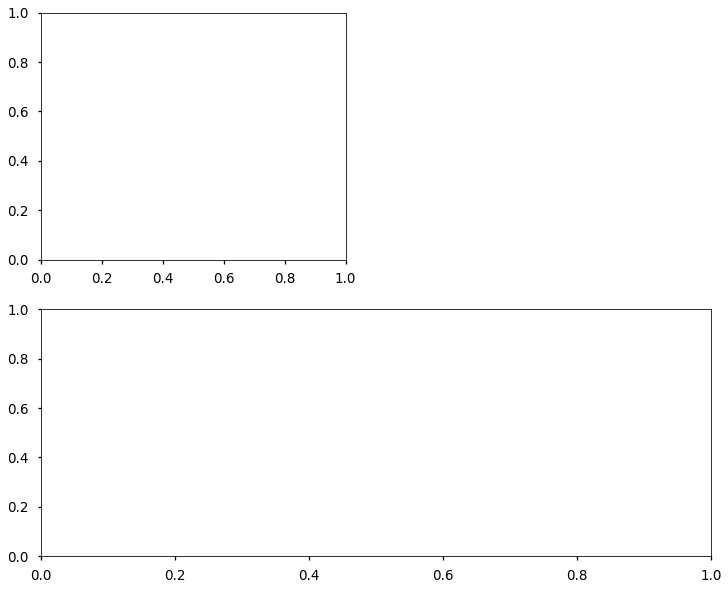

In [147]:
fig = plt.figure(figsize=(12, 10));
ax_gain = fig.add_subplot(221);
ax_height = fig.add_subplot(212);
fig;

In [148]:
ax_gain.scatter(realized_gain["size"], realized_gain["realized_gain"], 
                marker=".", label="Empirical")

APPROX_MAX = False
n_sibs_domain = np.linspace(2, realized_gain["size"].max(), 100)
expected_family_max = gauss_max_exp(n_sibs_domain, APPROX_MAX)
sigma_y = data["measured"].std()
r2_score = 0.273
h_p = np.sqrt(r2_score)
rho = 1
theoretical_curve = sigma_y * h_p * expected_family_max * rho / np.sqrt(2)
if APPROX_MAX:
    theoretical_curve *= np.sqrt(2)
ax_gain.plot(n_sibs_domain, theoretical_curve, label="Theoretical", alpha=0.9, color="C1")
# ax.legend(loc=(0.01, 0.1))
# ax.legend(loc=(0.55, 0.16))
ax_gain.legend(loc="lower right")
ax_gain.set_xlim(realized_gain["size"].min() - 1, ax_gain.get_xlim()[1])
ax_gain.xaxis.set_major_locator(plt.MaxNLocator(8, integer=True))
ax_gain.set_ylabel("Realized gain [cm]")
ax_gain.set_xlabel("# Embryos [n]");
# ax_gain.set_title("Large families");

In [149]:
import matplotlib.lines as mlines
# Plot all offspring without 
sns.stripplot(x="FID", y="measured", data=offspring_no_max, order=order, alpha=0.55,
              color="C7", marker="o", size=8, label="offspring", ax=ax_height)
# plot parents
sns.stripplot(x="FID", y="measured", data=parents, order=order,
              color="C0", marker="^", size=9.5, label="parents", ax=ax_height)
# Plot the actual of max predicted offspring
sns.stripplot(x="FID", y="measured", data=max_predicted_offspring, order=order,
              color="C3", marker="s", size=8, label="top-predicted", ax=ax_height)

ax_height.legend(handles=[mlines.Line2D([], [], color="C7", marker='o', linestyle='None',
                                 markersize=7, alpha=0.6, label='offspring'),
                   mlines.Line2D([], [], color='C3', marker='s', linestyle='None',
                                 markersize=7, label='top-predicted'),
                   mlines.Line2D([], [], color='C0', marker='^', linestyle='None',
                                 markersize=9, label='parents')],
          loc="lower left", ncol=3, columnspacing=0.1, handletextpad=0.1, labelspacing=0.1)
ax_height.set_ylabel("Height [cm]")
ax_height.set_xlabel("Family ID")
ax_height.tick_params(axis='both', pad=1.3)
# ax_height.set_title("Large-families measred height")
# ax.xaxis.set_tick_params(rotation=90)
ax_height.set_xticklabels(range(1, order.size + 1));

In [150]:
fig

In [151]:
plot.save_fig(fig, "large-fam_realized-gain-height-dot-plot-combined",
              SAVE_FIG_DIR)

Sample equal_size families

[]

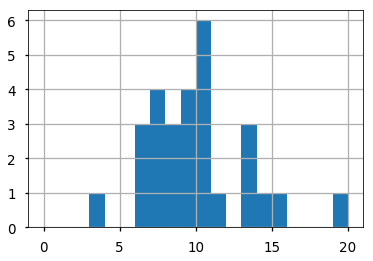

In [94]:
gain["size"].hist(bins=np.arange(gain["size"].max()+1)).plot()

In [96]:
desired_family_size = 7
print("Number of families before filter:", offspring.groupby("FID").ngroups)
offspring_eq_size = offspring.groupby("FID").filter(lambda x: x.shape[0] >= desired_family_size)
print("Number of families after  filter:", offspring_eq_size.groupby("FID").ngroups,)
offspring_eq_size = offspring_eq_size.groupby("FID").apply(lambda x: x.sample(n=desired_family_size))
offspring_eq_size = offspring_eq_size.set_index(["FID", "IID"])
offspring_eq_size.head()

Number of families before filter: 28
Number of families after  filter: 24


age  sex   predicted    measured
FID IID                                  
274 4     41    2  176.036211  166.437195
    7     35    1  171.844772  173.751998
    5     38    2  176.432082  169.612194
    3     42    2  174.885904  174.006001
    10    25    1  178.996054  180.549998

Gain

In [97]:
offspring_eq_size = offspring_eq_size.drop(columns=["age", "sex"])

In [98]:
gain_eq_size = offspring_eq_size.groupby("FID").agg(["max", "mean", "idxmax"])
gain_eq_size[("predicted", "top_predict_measured")] = \
    offspring_eq_size.loc[gain_eq_size[("predicted", "idxmax")], "measured"].reset_index("IID", drop=True)
gain_eq_size = gain_eq_size.sort_index(axis="columns")
gain_eq_size = gain_eq_size.apply(lambda x: x.apply(pd.Series)[1] if x.name[1].startswith("idxmax") else x)
gain_eq_size = gain_eq_size.stack(level=0).swaplevel().sort_index()
gain_eq_size.sample(6)

idxmax         max        mean  top_predict_measured
          FID                                                      
measured  283       9  180.524999  173.503870                   NaN
          293       3  184.077082  175.701147                   NaN
          286       7  178.676918  171.237767                   NaN
          300       8  181.684571  175.434095                   NaN
          295      15  189.025003  180.816774                   NaN
predicted 275       9  177.256673  168.758699            174.207673

In [105]:
def compute_realized_gain(b):
    """b is a data frame with FID IID as index and two columns - predicted and measured values"""
    idx_max_predicted = b["predicted"].groupby("FID").idxmax()
    measured_of_top_predicted = b.loc[idx_max_predicted, "measured"]
    measured_of_top_predicted = measured_of_top_predicted.reset_index("IID", drop=True)
    actual_intrafamily_mean = b["measured"].groupby("FID").mean()
    res = pd.concat([measured_of_top_predicted.rename("top_predict_measured"), 
                     actual_intrafamily_mean.rename("measured_mean")],
                    axis="columns")
    return res

In [106]:
a = offspring.groupby("FID").filter(lambda x: x.shape[0] >= desired_family_size)
a = a.drop(columns=["age", "sex"])
resampled_realized_gain = []
n_resamples = 10
for i in range(n_resamples):
    b = a.groupby("FID").apply(lambda x: x.sample(n=desired_family_size))
    b = b.set_index(["FID", "IID"])
    c = compute_realized_gain(b)
    c = c["top_predict_measured"] - c["measured_mean"]
    resampled_realized_gain.append(c)
resampled_realized_gain = pd.concat(resampled_realized_gain)

In [107]:
print("number of families with negative gain:")
resampled_realized_gain.loc[resampled_realized_gain < 0].index.to_series().value_counts()
resampled_realized_gain.loc[resampled_realized_gain < -3].index.to_series().value_counts()
resampled_realized_gain.describe().rename("resampled").to_frame().join((gain_eq_size.xs("predicted")["top_predict_measured"] - 
                                                                        gain_eq_size.xs("measured")["mean"]).describe()
                                                                        .rename("original"))

number of families with negative gain:


resampled   original
count  240.000000  24.000000
mean     2.814946   2.635140
std      3.397739   4.084223
min     -8.381345  -5.584684
25%      1.623013  -0.318057
50%      3.169546   2.849162
75%      4.981702   5.409225
max      9.685953   9.587852

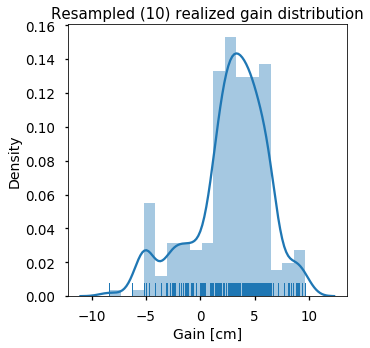

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.distplot(a=resampled_realized_gain, 
             hist=True, kde=True, rug=True, norm_hist=True,
             label=None, axlabel="Gain [cm]", ax=ax)
ax.set_title("Resampled ({}) realized gain distribution".format(n_resamples))
ax.set_xlabel("Gain [cm]")
ax.set_ylabel("Density");

In [110]:
plot.save_fig(fig, "large-fam_gain-realized_resample_distribution_n={}_k={}".format(desired_family_size, n_resamples),
              SAVE_FIG_DIR)

Compare ranks

In [113]:
a = gain_eq_size["idxmax"].unstack(level=0)
print("Number of correctly ranked:", (a["measured"] == a["predicted"]).sum(), 
      "from total of:", a.shape[0])

Number of correctly ranked: 8 from total of: 24


In [114]:
ranks = offspring_eq_size.groupby("FID").rank(ascending=False)
ranks.head()

predicted  measured
FID IID                     
274 4          3.0       6.0
    7          6.0       4.0
    5          2.0       5.0
    3          5.0       2.0
    10         1.0       1.0

In [116]:
max_predicted_idx = gain_eq_size.xs("predicted").set_index("idxmax", append=True).index
max_predicted_rank = ranks.loc[max_predicted_idx, "measured"]
print("Number of top predicted being in the actual top half :",
      (max_predicted_rank <= desired_family_size // 2).sum(),
      "out of total of:", max_predicted_rank.shape[0])
print("Number of top predicted being in the actual top third:",
      (max_predicted_rank <= desired_family_size // 3).sum(),
      "out of total of:", max_predicted_rank.shape[0])

Number of top predicted being in the actual top half : 16 out of total of: 24
Number of top predicted being in the actual top third: 12 out of total of: 24


In [117]:
max_measured_idx = gain_eq_size.xs("measured").set_index("idxmax", append=True).index
max_measured_rank = ranks.loc[max_measured_idx, "predicted"]
print("Number of actual highest being in the predicted top half :",
      (max_measured_rank <= desired_family_size // 2).sum(),
      "out of total of:", max_predicted_rank.shape[0])
print("Number of actual highest being in the predicted top third:",
      (max_measured_rank <= desired_family_size // 3).sum(),
      "out of total of:", max_measured_rank.shape[0])

Number of actual highest being in the predicted top half : 17 out of total of: 24
Number of actual highest being in the predicted top third: 11 out of total of: 24


In [118]:
# How did the ranks move - each top-predicted, where did it land in measured and vice versa:
top_rank_shift = pd.concat([max_measured_rank.reset_index("idxmax", drop=True).rename("top_predict_to_measure"),
                            max_predicted_rank.reset_index("idxmax", drop=True).rename("top_measure_to_predict")],
                           axis="columns")
top_rank_shift.sample(3)

top_predict_to_measure  top_measure_to_predict
FID                                                
290                     2.0                     5.0
296                     5.0                     3.0
294                     2.0                     2.0

In [120]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for _, row in top_rank_shift.iterrows():
    rp = row["top_predict_to_measure"]
    rm = row["top_measure_to_predict"]
    ax.plot(["a", "b"], [1, rp], marker="o", color="C0", alpha=0.4, 
            markersize=(top_rank_shift["top_predict_to_measure"] == rp).sum() + 6)
    ax.plot(["a", "b"], [rm, 1], marker="o", color="C1", alpha=0.4,
            markersize=(top_rank_shift["top_measure_to_predict"] == rm).sum() + 6)
# ax.legend(handles=[mlines.Line2D([], [], color='C0', marker='o', markersize=8, alpha=0.8, label='predicted'),
#                    mlines.Line2D([], [], color='C1', marker='o', markersize=8, alpha=0.8, label='measured')],
#           loc="upper center")
ax.set_xticklabels(["predicted", "measured"])
ax.set_ylabel("Rank")
ax.set_title("Rank comparison of top offspring");

In [47]:
plot.save_fig(fig, "large-fam_rank-slope_top_diffsize_n={}".format(desired_family_size),
              SAVE_FIG_DIR)

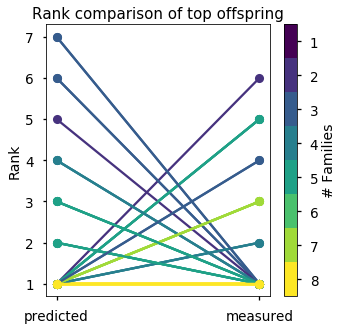

In [121]:
from matplotlib import colors
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

n_colors = max(top_rank_shift["top_predict_to_measure"].value_counts().max(),
               top_rank_shift["top_measure_to_predict"].value_counts().max())

cmap = plt.get_cmap('viridis', n_colors)
# cmap = colors.ListedColormap(cmap(np.linspace(0.0, 0.9), 256))
# cmap = plt.get_cmap('viridis_r', n_colors)
# cmap = plt.get_cmap('YlGnBu_r', n_colors)
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=colors.Normalize(vmin=1, vmax=n_colors + 1))
sm.set_array([])


for _, row in top_rank_shift.iterrows():
    rp = row["top_predict_to_measure"]
    rm = row["top_measure_to_predict"]
    ax.plot(["a", "b"], [1, rp], marker="o", 
            c=cmap((top_rank_shift["top_predict_to_measure"] == rp).sum()))
    ax.plot(["a", "b"], [rm, 1], marker="o",
            color=cmap((top_rank_shift["top_measure_to_predict"] == rm).sum()))
ax.set_ylabel('Rank')
ax.set_xticklabels(["predicted", "measured"])
ax.set_title("Rank comparison of top offspring")
cbar = plt.colorbar(sm, 
                    ticks=np.arange(0.5, n_colors + 1.5),
                    format="%d"
                   )
cbar.ax.invert_yaxis()
cbar.set_label("# Families")

In [101]:
plot.save_fig(fig, "large-fam_rank-slope_top_colorbar_n={}".format(desired_family_size),
              SAVE_FIG_DIR)

Predicting probabilty of top-predicted being actual tallest

In [211]:
desired_family_size = 7
a = offspring.groupby("FID").filter(lambda x: x.shape[0] >= desired_family_size)
a = a.drop(columns=["age", "sex"])
fraction_of_top_to_top = []
n_resamples = 100
for i in range(n_resamples):
    b = a.groupby("FID").apply(lambda x: x.sample(n=desired_family_size))
    b = b[["measured", "predicted"]].groupby("FID").idxmax()
    sample_top_to_top_fraction = (b["measured"] == b["predicted"]).mean()
    fraction_of_top_to_top.append(sample_top_to_top_fraction)
fraction_of_top_to_top = pd.Series(fraction_of_top_to_top)

count    100.000000
mean       0.315000
std        0.077062
min        0.083333
25%        0.250000
50%        0.333333
75%        0.375000
max        0.500000
dtype: float64

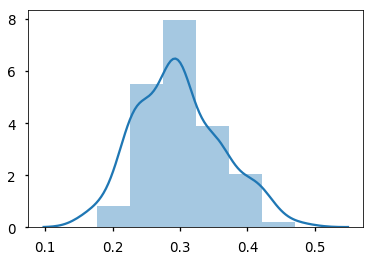

In [212]:
sns.distplot(fraction_of_top_to_top);
fraction_of_top_to_top.describe()

Difference between the top-predicted and actual tallest

In [242]:
a = offspring.loc[offspring.groupby("FID")["predicted"].idxmax()]
print((offspring.groupby("FID")["measured"].max() - 
       offspring.loc[offspring.groupby("FID")["predicted"].idxmax()].set_index("FID")['measured']).agg(["mean", "std"]))
desired_family_size = 7
a = offspring.groupby("FID").filter(lambda x: x.shape[0] >= desired_family_size)
a = a.drop(columns=["age", "sex"])
actual_top_to_actual_pred_top_diff = []
n_resamples = 100
for i in range(n_resamples):
    b = a.groupby("FID").apply(lambda x: x.sample(n=desired_family_size)).reset_index(drop=True)
    c = b.loc[b.groupby("FID")["predicted"].idxmax()].set_index("FID")["measured"]
    diff = (b.groupby("FID")["measured"].max() - c).mean()
    actual_top_to_actual_pred_top_diff.append(diff)
actual_top_to_actual_pred_top_diff = pd.Series(actual_top_to_actual_pred_top_diff)
actual_top_to_actual_pred_top_diff.describe()

mean    3.508703
std     4.142716
Name: measured, dtype: float64


count    100.000000
mean       2.978771
std        0.426432
min        2.211458
25%        2.667220
50%        2.922795
75%        3.303386
max        4.093543
dtype: float64

In [257]:
a = offspring.loc[offspring.groupby("FID")["predicted"].idxmax()]
print((a["measured"] - a["predicted"]).var())
desired_family_size = 7
a = offspring.groupby("FID").filter(lambda x: x.shape[0] >= desired_family_size)
a = a.drop(columns=["age", "sex"])
variances_of_top_diff = []
n_resamples = 100
for i in range(n_resamples):
    b = a.groupby("FID").apply(lambda x: x.sample(n=desired_family_size)).reset_index(drop=True)
    b = b.loc[b.groupby("FID")["predicted"].idxmax()]
    diff_variance = (b["measured"] - b["predicted"]).var()
    variances_of_top_diff.append(diff_variance)
variances_of_top_diff = pd.Series(variances_of_top_diff)
variances_of_top_diff.describe()

20.69925687732005


count    100.000000
mean      22.033093
std        4.505917
min       10.031459
25%       19.196828
50%       21.952930
75%       24.545009
max       34.337133
dtype: float64

In [7]:
def compute_realized_gain(b):
    """b is a data frame with FID IID as index and two columns - predicted and measured values"""
    idx_max_predicted = b["predicted"].groupby("FID").idxmax()
    measured_of_top_predicted = b.loc[idx_max_predicted, "measured"]
    measured_of_top_predicted = measured_of_top_predicted.reset_index("IID", drop=True)
    actual_intrafamily_mean = b["measured"].groupby("FID").mean()
    res = pd.concat([measured_of_top_predicted.rename("top_predict_measured"), 
                     actual_intrafamily_mean.rename("measured_mean")],
                    axis="columns")
    return res

In [244]:
desired_family_size = 7
a = offspring.groupby("FID").filter(lambda x: x.shape[0] >= desired_family_size)
a = a.drop(columns=["age", "sex"])
resampled_realized_gain = []
n_resamples = 100
for i in range(n_resamples):
    b = a.groupby("FID").apply(lambda x: x.sample(n=desired_family_size))
    b = b.set_index(["FID", "IID"])
    c = compute_realized_gain(b)
    c = c["top_predict_measured"] - c["measured_mean"]
    resampled_realized_gain.append(c)
resampled_realized_gain = pd.concat(resampled_realized_gain)
resampled_realized_gain.describe()

count    2400.000000
mean        2.963652
std         3.507131
min        -8.381345
25%         1.551227
50%         3.112170
75%         5.126773
max        11.076905
dtype: float64

In [25]:
desired_family_size = 7
a = offspring.groupby("FID").filter(lambda x: x.shape[0] >= desired_family_size)
a = a.drop(columns=["age", "sex"])
prop_of_negative_gain = []
n_resamples = 100
for i in range(n_resamples):
    b = a.groupby("FID").apply(lambda x: x.sample(n=desired_family_size))
    b = b.set_index(["FID", "IID"])
    c = compute_realized_gain(b)
    c = ((c["top_predict_measured"] - c["measured_mean"]) < 0).mean()
    prop_of_negative_gain.append(c)
prop_of_negative_gain = pd.Series(prop_of_negative_gain)
prop_of_negative_gain.describe()

count    100.000000
mean       0.165417
std        0.055383
min        0.041667
25%        0.125000
50%        0.166667
75%        0.208333
max        0.291667
dtype: float64